In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.1.0


In [23]:
# https://stackoverflow.com/questions/57469676/python-one-hot-encoding-for-comma-separated-values
def one_hot_encode(df):
    dummies = df['subjects'].str.get_dummies(sep=",")
    df_copy = pd.concat([df.drop('subjects', 1), dummies], 1)
    return (df_copy, dummies.columns)

In [15]:
train = pd.read_csv('train.tsv', delimiter='\t', header=None)
val = pd.read_csv('valid.tsv', delimiter='\t', header=None)
test = pd.read_csv('test.tsv', delimiter='\t', header=None)
rename_columns = ['ID', 'label', 'statement', 'subjects', 'speaker', 'speaker_job_title', 'state_info',
                  'party_affiliation', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire',
                  'context'
                 ]
train.columns = rename_columns
val.columns = rename_columns
test.columns = rename_columns
all_data = pd.concat([train, val, test])

# X_train, y_train = train.drop(drop_columns, axis=1), train['label']
# X_val, y_val = val.drop(drop_columns, axis=1), val['label']
# X_test, y_test = test.drop(drop_columns, axis=1), test['label']

In [16]:
train.head()

,ID,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,barely_true,false,half_true,mostly_true,pants_on_fire,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [17]:
# deal with NaNs
print('Train', train.isna().sum().to_dict())
print('Train length: ', len(train))
print('Val: ', val.isna().sum().to_dict())
print('Val length: ', len(val))
print('Test: ', test.isna().sum().to_dict())
print('Test length: ', len(test))

Train {'ID': 0, 'label': 0, 'statement': 0, 'subjects': 2, 'speaker': 2, 'speaker_job_title': 2897, 'state_info': 2208, 'party_affiliation': 2, 'barely_true': 2, 'false': 2, 'half_true': 2, 'mostly_true': 2, 'pants_on_fire': 2, 'context': 102}
Train length:  10240
Val:  {'ID': 0, 'label': 0, 'statement': 0, 'subjects': 0, 'speaker': 0, 'speaker_job_title': 345, 'state_info': 279, 'party_affiliation': 0, 'barely_true': 0, 'false': 0, 'half_true': 0, 'mostly_true': 0, 'pants_on_fire': 0, 'context': 12}
Val length:  1284
Test:  {'ID': 0, 'label': 0, 'statement': 0, 'subjects': 0, 'speaker': 0, 'speaker_job_title': 325, 'state_info': 262, 'party_affiliation': 0, 'barely_true': 0, 'false': 0, 'half_true': 0, 'mostly_true': 0, 'pants_on_fire': 0, 'context': 17}
Test length:  1267


<BarContainer object of 147 artists>

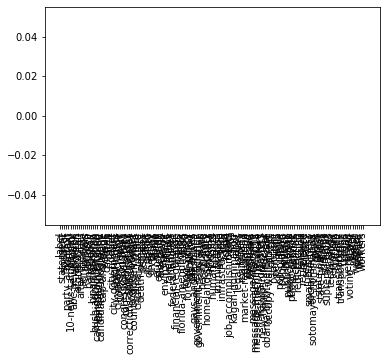

In [87]:
train_NaN = train.isna().sum().to_dict()
plt.xticks(rotation=90)
plt.bar(train_NaN.keys(), train_NaN.values(), align='edge')

In [19]:
'''
General:
ID: is extraneous information
speaker truth value counts: data leakage? this seems to include possible future information in the dataset?

NaNs:
drop speaker_job_title and state_info because just way too many NaNs to be able to fill them well with dummy values
context doesn't have too many but not sure I could use it. Since they are sentence, I think an empty string could be interpretd as no information
all other NaN were dropped by row
'''
drop_columns = ['ID', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'speaker_job_title',
               'state_info']
train.drop(drop_columns, axis=1, inplace = True)
train['context'].fillna('', inplace = True)
train.dropna(axis=0, how='all', subset=['subjects'], inplace=True)
train.dropna(axis=0, how='all', subset=['speaker'], inplace=True)
train.dropna(axis=0, how='all', subset=['party_affiliation'], inplace=True)

val.drop(drop_columns, axis=1, inplace = True)
val['context'].fillna('', inplace = True)
val.dropna(axis=0, how='all', subset=['subjects'], inplace=True)
val.dropna(axis=0, how='all', subset=['speaker'], inplace=True)
val.dropna(axis=0, how='all', subset=['party_affiliation'], inplace=True)

test.drop(drop_columns, axis=1, inplace = True)
test['context'].fillna('', inplace = True)
test.dropna(axis=0, how='all', subset=['subjects'], inplace=True)
test.dropna(axis=0, how='all', subset=['speaker'], inplace=True)
test.dropna(axis=0, how='all', subset=['party_affiliation'], inplace=True)

10238
half-true      2114
false          1993
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: label, dtype: int64


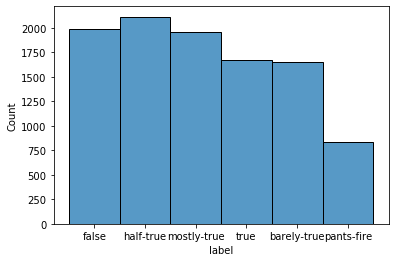

In [20]:
# histogram of labels to check for class imbalance
print(len(train['label']))
sns.histplot(data=train['label'])
print(train['label'].value_counts())

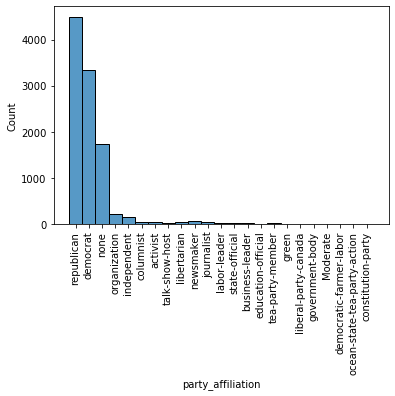

In [21]:
# histogram of party affiliation
'''
this could be an issue, some of these groups like tea_party_member are part of the Republican Party 
but that isn't considered here. How would model understand that a tea_party_member might share some 
ideas with Republican Party. Will be worth to see how well these points end up getting classified if
party_affiliation becomes an important feature
'''
g = sns.histplot(data=train['party_affiliation'])
g.set_xticklabels(labels=train['party_affiliation'].unique() ,rotation=90)
print()

In [138]:
# correlation matrix - not that useful because it only works with numerical features
sns.heatmap(train.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, 
            center= 0, cmap= 'coolwarm', square=True, mask=np.triu(train.corr()))

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f7fc05603b0> (for post_execute):


KeyboardInterrupt: 

In [24]:
# one hot encode
train, subject_cols = one_hot_encode(train)

In [68]:
# check relationships between subjects and labels
print(subject_cols)
subject_dict = {}
label_types = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
for lt in label_types:
    for s in subject_cols:
#         temp = train.apply(lambda x : True 
#                             if x[s] == 1 and x['label'] == lt else False, axis = 1)
#         count = len(temp[temp == True].index)
#         print(count)
        count = train[(train[s] == 1) & (train['label'] == lt)].count()[0] # label is at 0th index
#         print(count)
#         print('s: {} lt: {}'.format(s, lt))
        if subject in subject_dict:
            subject_dict[s].append(count)
        else:
            subject_dict[s] = [count]
    print('finished: ', lt)

Index(['10-news-tampa-bay', 'Alcohol', 'abc-news-week', 'abortion',
       'afghanistan', 'after-the-fact', 'agriculture', 'animals', 'autism',
       'bankruptcy',
       ...
       'unions', 'urban', 'veterans', 'voting-record', 'water', 'wealth',
       'weather', 'welfare', 'women', 'workers'],
      dtype='object', length=142)
finished:  pants-fire
finished:  false
finished:  barely-true
finished:  half-true
finished:  mostly-true
finished:  true


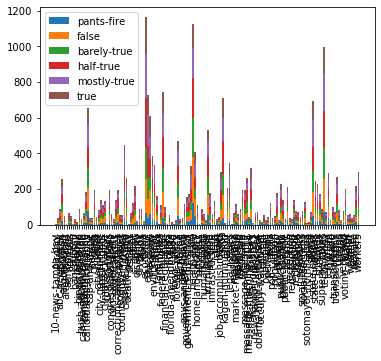

In [112]:
fig, ax = plt.subplots()
for i in range(len(label_types)):
#     counts = [x[i] for x in subject_dict.values()]
# #     print(counts)
#     ax.bar(subject_cols, counts)
    counts = [x[i] for x in subject_dict.values()]
#     print(counts)
    if i == 0:
        ax.bar(subject_cols, counts, label=label_types[i])
        sum_counts = counts
    else:
        ax.bar(subject_cols, counts, bottom=sum_counts, label=label_types[i])
        sum_counts = [i + j for i,j in zip(sum_counts, counts)]
plt.legend(label_types)
plt.xticks(rotation=90)
plt.show()

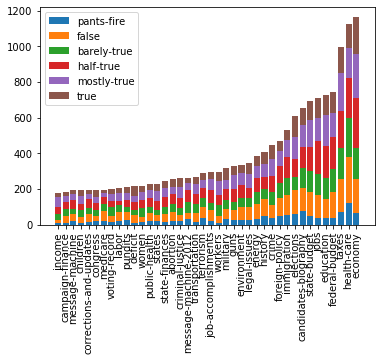

In [110]:
sorted_tuples = sorted(subject_dict.items(), key=lambda item: np.sum(item[1]))
k = 40
topk_subjects = sorted_tuples[-k:]
# print(topk_subjects)  # [(1, 1), (3, 4), (2, 9)]

topk_subject_names = [x[0] for x in topk_subjects]
fig, ax = plt.subplots()

for i in range(len(label_types)):
    counts = [x[1][i] for x in topk_subjects]
#     print(counts)
    if i == 0:
        ax.bar(topk_subject_names, counts, label=label_types[i])
        sum_counts = counts
    else:
        ax.bar(topk_subject_names, counts, bottom=sum_counts, label=label_types[i])
        sum_counts = [i + j for i,j in zip(sum_counts, counts)]
#     print(sum_counts)
plt.xticks(rotation=90)
plt.legend()
plt.show()